In [113]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [114]:
dataset_name = "W16_comb"
df_list = [ "BES_Panel", ]

In [115]:
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

In [116]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [117]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show,  output_notebook
from bokeh.layouts import column, row
from bokeh.embed import components
output_notebook()

Loading BokehJS ...

In [6]:
## Step One: Locate the period of the Major Shift In Sentiment
## - Find all the directly-immigration-related sentiment variables

# split into "about me" (immigSelf)
#            "about party" (immigCon)

In [107]:
immig_var_stub = ["immigEcon","immigCultural","immigSelf","immigrationLevel","immigContributeTake",
                  "immigrantsWelfareState","controlImmig","effectsEUImmigration","euPriorityBalance",
                  "changeImmig","changeImmigLab","govtHandleImmig","labHandleImmig",
                  "asylumMore","euMore","noneuMore","studentsMore","familiesMore"]

# %%time
df = BES_Panel.apply(lambda x: cat_2_num_drop_dk(x))

df = BES_Panel[BES_Panel.columns[BES_Panel.dtypes=='category']].apply(lambda x: x.cat.codes).copy()

# %%time
mask = immigSelfW16.notnull()

corr_series = df[mask].select_dtypes(include=np.number).astype('float32').corrwith(immigSelfW16[mask].astype('float32'))

# POST W13 Variables to add in

# dealPriorityMarketAccess
# effectsEUUnemployment
# dealPrioritgImmig


# W15 only possibleImmigNI,possibleMarketsImmig,possibleImmigTrade,noDealResults_6
# W4 tryReduceImmig

In [123]:
# use these variables for now, edit Later

In [249]:
immig_var_stub = ["immigEcon","immigCultural","immigSelf","immigrationLevel","immigContributeTake",
                  "immigrantsWelfareState","controlImmig","effectsEUImmigration","euPriorityBalance",
                  "changeImmig","changeImmigLab","govtHandleImmig","labHandleImmig",
                  "asylumMore","euMore","noneuMore","studentsMore","familiesMore",
                  "responsibleImmig","achieveReduceImmig",
                  "conPriorities_immig","labPriorities_immig","ldPriorities_immig","ukipPriorities_immig"]

In [330]:
# Fix up all the datasets we'll be using (make sure all categories correctly/consistently ordered)


fix_cat_dict = {}
# not sure about best way to line up "expectation" variables
fix_cat_dict['changeImmig']=['Getting a lot lower', 'Getting a little lower','Staying about the same',
                             'Getting a little higher', 'Getting a lot higher',  "Don't know" ]
fix_cat_dict['effectsEUImmigration'] = ['Much lower', 'Lower', 'About the same', 'Higher', 'Much higher', "Don't know"]
fix_cat_dict['controlImmig']=['No control at all', 'A little control', 'Some control', 'A lot of control', 'Complete control', "Don't know"]

# lets try to get every axis pointing in the same "sentiment" direction
fix_cat_dict['immigEcon']=['Bad for economy','2', '3', '4', '5', '6', 'Good for economy',  "Don't know"]
fix_cat_dict['immigCultural']=['Undermines cultural life', '2', '3', '4', '5', '6', 'Enriches cultural life', "Don't know" ]
fix_cat_dict["immig(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)W"] = ['Allow many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Allow many more', "Don't know"]
fix_cat_dict['(students|eu|asylum|families|noneu)More'] = ['Many fewer', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Many more', "Don't know"]
fix_cat_dict['immigrantsWelfareState'] = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "Don't know"]
fix_cat_dict['immigContributeTake'] = ['Get more than they pay', '2.0', '3.0', '4.0',
                                       '5.0', '6.0', 'Pay more than they get', "Don't know"]
fix_cat_dict['euPriorityBalance'] = ['Control immigration', '9', '8', '7', '6', '5', '4', '3', '2', '1', 'Access to the single market', "Don't know"]
fix_cat_dict['immigrationLevel'] = ['Decreased a lot', 'Decreased a little', 'Left the same as it is now',
                                    'Increased a little', 'Increased a lot',  "Don't know"]


# fix_cat_dict['immigrantsWelfareState'] = ['Strongly disagree', 'Disagree',  'Neither agree nor disagree','Agree', 'Strongly agree',"Don't know", ]
# mostly dealPrioritImmig, but might be worth setting alongside the other dealPriority variables
fix_cat_dict['dealPriority'] = ['Not important at all', 'Not very important', 'Somewhat important',
                                'Very important', 'Extremely important' , "Don't know"]

# fix_cat_dict['euPriorityBalance'] = ['Access to the single market', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Control immigration', "Don't know"]
fix_cat_dict['(lab|govt)HandleImmig'] = ['Very badly', 'Fairly badly', 'Neither well nor badly', 'Fairly well', 'Very well', "Don't know"]

fix_cat_dict['responsibleImmig(Conservatives|LibDems|Labour|ScottishGovt|WelshGovt|None|DontKnow)'] = ["No","Yes","Don't know"]
fix_cat_dict['achieveReduceImmig(Brexit|Con|Grn|LD|Lab|None|PC|SNP|TIG|UKIP)'] = ["No","Yes","Don't know"]

fix_cat_dict["(con|lab|ld|ukip)Priorities_immig"] = ["No","Yes","Don't know"]



def cat_2_num_drop_dk(x):
    if x.dtype.name=='category':
        return x.replace("Don't know",np.nan).cat.remove_unused_categories().cat.codes.replace(-1,np.nan).astype('UInt16')
    else:
        return x

def fix_cats(fix_cat_dict):
    for key in fix_cat_dict.keys():
        BES_Panel[ match(BES_Panel, key ).index ] = BES_Panel[ match(BES_Panel,key ).index ]\
            .apply( lambda x: x.cat.set_categories( fix_cat_dict[key], ordered =True ) )
    
fix_cats(fix_cat_dict)

def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    return (val * weight).sum() / weight.sum()

max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
wave_to_date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")["Date_Start"]

# fix endtimeW3 bug!
BES_Panel.loc[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00',"endtimeW3"] = \
    BES_Panel[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00']["starttimeW3"].values

# this is also suspect - date not unreasonable, but overlaps with a different wave! (3 days between start/end)
# 41222   2015-03-27 18:11:37.047
# Name: starttimeW5, dtype: datetime64[ns]
BES_Panel.loc[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064',"starttimeW5"] = \
    BES_Panel[BES_Panel["starttimeW5"]=='2015-03-27 18:11:37.047000064']["endtimeW5"].values

# still some overlap between waves 4 and 5


# create correct midpoints (technically we should weight these!)
n = 1
for wave_no in range(1,max_wave+1):
    wave = "W"+str(wave_no)
#     print(wave)

    BES_Panel["midpoint"+wave] = pd.qcut(BES_Panel["endtime"+wave]+((BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2),n)
    date_cats_dict = {BES_Panel["midpoint"+wave].cat.categories[x]:(BES_Panel["midpoint"+wave].cat.categories[x].left+ (BES_Panel["midpoint"+wave].cat.categories[x].right - BES_Panel["midpoint"+wave].cat.categories[x].left)/2).strftime("%Y-%m-%d") for x in range(n)}
    BES_Panel["midpoint"+wave] = pd.to_datetime(BES_Panel["midpoint"+wave].replace(date_cats_dict))  
    BES_Panel["endpoint"+wave] = pd.to_datetime(BES_Panel["endtime"+wave]).max() 
    BES_Panel["startpoint"+wave] = pd.to_datetime(BES_Panel["starttime"+wave]).min() 

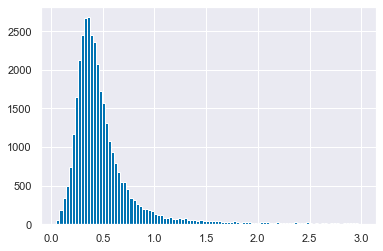

In [143]:
# quick sanity check on BES session times (duration in hours)
dur = ( BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave] ).apply(lambda x: x/np.timedelta64(1, 'h'))
dur[dur<=3].hist(bins=100);

In [301]:
def time_series(var_name,title,subtract_var=False,retain_var=True,specific_dates=True, specific_suffix_set="([a-zA-Z]*)",
                use_midpoints=True,col_name="party",dk_str="Don't know",max_y_size=10.0,min_waves_included=2,max_y_size_dict=None):

    df=pd.DataFrame()
    df2 =pd.DataFrame()
    df_wts =pd.DataFrame()
    df_dates = pd.DataFrame()
    
    if subtract_var:
        title=title+"\n(where respondents place parties relative to their own preference set at 0.5)"

    wave_list = []
    redist_vars = pd.Series([re.match(var_name+specific_suffix_set+"($|W\d+)",x).groups()[0] for x in BES_Panel.columns\
                             if re.match(var_name+specific_suffix_set+"($|W\d+)",x)]).value_counts()
    redist_vars = redist_vars[redist_vars>=min_waves_included].index

    for subj in redist_vars:
        for wave in ["W"+str(x) for x in range(1,17)]:
            if var_name+subj+wave not in BES_Panel.columns:
                continue
            else:
                wave_list.append(wave)
            if max_y_size_dict:
                max_y_size = max_y_size_dict[subj]
            df[var_name+"num_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave].replace(dk_str,np.nan).cat.codes.replace(-1,np.nan)/max_y_size
            df2[var_name+"dk_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave]==dk_str
            df2[var_name+"dk_"+subj+"_"+wave][BES_Panel[var_name+subj+wave].isnull()] = np.nan
            
            
    for wave in pd.unique(wave_list):        
        df_wts["wt_"+wave] = BES_Panel[wts_for_wave[wave]]
        
        if use_midpoints:
            df_dates["dt_"+wave] = BES_Panel["midpoint"+wave]
        else:
            df_dates["dt_"+wave] = (BES_Panel["starttime"+wave]+(BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2)
#             .apply(lambda x:x.date())

#     set_trace()
    df_wts = df_wts[df.notnull().any(axis=1)]
    df = df[df.notnull().any(axis=1)]

    df2.columns = df2.columns.str.split('_', expand=True)
    df2 = df2.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_wts.columns = df_wts.columns.str.split('_', expand=True)
    df_wts = df_wts.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_dates.columns = df_dates.columns.str.split('_', expand=True)
    df_dates = df_dates.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df.columns = df.columns.str.split('_', expand=True)
    df = df.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

    df["wt"] = df_wts["wt"]

    df = df.loc[ df[[x for x in df.columns if var_name+"num" in x]].notnull().any(axis=1) ]
    df.loc[:,"wt"] = df.loc[:,"wt"].fillna(1.0).values
    temp_ind_name = "temp_index"

    if specific_dates:
        df["date"] = df[["id","wave"]].merge(right=df_dates,
                 how="left",left_on=["id","wave"],right_on=["id","wave"])["dt"].values

    df[temp_ind_name] = list(zip(df["wave"],df["wt"],df["date"]))
    df = df.set_index(temp_ind_name).drop(["id","wave","wt","date"],axis=1)

    df2["wt"] = df_wts["wt"]

    if subtract_var:
        if retain_var:
            focal_vars = [x for x in df.columns if (var_name+"num" in x) and (subtract_var not in x)]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
        else:
            focal_vars = [x for x in df.columns if var_name+"num" in x]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
            df.drop((var_name+"num",  subtract_var),axis=1,inplace=True)


    df2 = df2.loc[ df2[[x for x in df2.columns if var_name+"dk" in x]].notnull().any(axis=1) ]
    df2.loc[:,"wt"] = df2.loc[:,"wt"].fillna(1.0).values
    if specific_dates:
        df2["date"] = df2[["id","wave"]].merge(right=df_dates,
                 how="left",left_on=["id","wave"],right_on=["id","wave"])["dt"].values

    temp_ind_name = "temp_index"
    df2[temp_ind_name] = list(zip(df2["wave"],df2["wt"],df2["date"]))
    df2 = df2.set_index(temp_ind_name).drop(["id","wave","wt","date"],axis=1)


    flat_df_num = df.stack().reset_index().rename(columns={'level_1':col_name})

    if specific_dates:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))

    flat_df_num["wt"]   = flat_df_num[temp_ind_name].apply(lambda x:x[1])
    flat_df_num["date"] = flat_df_num[temp_ind_name].apply(lambda x:x[2])
    
    
    
    flat_df_num.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_num[col_name] = flat_df_num[col_name].astype('category')

    flat_df_num[var_name+"_wts"] = list(zip(flat_df_num[var_name+"num"],flat_df_num["wt"]))

    flat_df_dk = df2.stack().reset_index().rename(columns={'level_1':col_name,0:"dk"})
    if specific_dates:
        flat_df_dk["wave"] = flat_df_dk[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_dk["wave"] = flat_df_dk[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))

    flat_df_dk["wt"]   = flat_df_dk[temp_ind_name].apply(lambda x:x[1])
    flat_df_dk["date"] = flat_df_dk[temp_ind_name].apply(lambda x:x[2])
    
    flat_df_dk.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_dk[var_name+"dk"] = flat_df_dk[var_name+"dk"].astype('int')
    flat_df_dk = flat_df_dk.groupby(["wave",col_name]).apply(lambda x: (x["wt"]*x[var_name+"dk"]).sum()/x["wt"].sum() ).reset_index().rename(columns={0:"dk"})

    flat_df_num = flat_df_num.merge(right=flat_df_dk[[col_name,"wave","dk"]],how='left',left_on=[col_name,"wave"],right_on=[col_name,"wave"])
    if not specific_dates:
        flat_df_num["date"] = flat_df_num["wave"].apply(lambda x: wave_to_date[x])
        flat_df_num["date"] = pd.to_datetime(flat_df_num["wave"] , format="%b-%y")

    return flat_df_num, df, df2, 

In [229]:
def sample_size(x, **kws):
    global max_sample_size    
    return len(x)/max_sample_size

def between_wave_retention(*args, **kwargs):
    global position_in_var_list
    var_name = kwargs['var_name'][position_in_var_list]
    position_in_var_list = position_in_var_list+1
    color = kwargs['color']
    label = kwargs['label']
    alpha = kwargs['alpha']
    df = BES_Panel[match(BES_Panel,var_name).index].apply(lambda x: x.cat.codes.replace(-1,np.nan)).diff(axis=1).notnull().sum()/match(BES_Panel,var_name)
    waves_present = {"W"+x.split("W")[-1]:BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index}    
    df.index = [BES_Panel["midpointW"+x.split("W")[-1]].dropna().values[0] for x in df.index]
    df.drop(df.index[0],inplace=True)
    sns.lineplot(data=df,color=color,label=label,alpha=alpha)

    for wave in waves_present.keys():
        plt.text(x=waves_present[wave],y=0,s=wave, rotation=90, fontsize=12)   
        
def plot_time_series(var_name,specific_suffix_set,title,col_name,col_wrap,treatment):
    dk_str="Don't know"
    max_y_size_dict = {x: len(BES_Panel[match(BES_Panel,var_name+x+"($|W\d+)").index[0]].cat.remove_categories(dk_str).cat.categories)-1 for x in specific_suffix_set.replace("(","").replace(")","").split("|") }
    # max_y_size=len(BES_Panel[ match(BES_Panel,var_name+specific_suffix_set+"($|W\d+)").index[0] ].cat.remove_categories(dk_str).cat.categories)-1,
    flat_df_num, df, df2, = time_series(var_name,title,specific_suffix_set=specific_suffix_set,col_name="party",
                                max_y_size_dict = max_y_size_dict,
                                dk_str=dk_str,min_waves_included=2,use_midpoints=True)
    
    date_dict = {"22 May 2014":"EE","7 May 2015":"GE","23 June 2016":"EU","8 June 2017":"GE","23 May 2019":"EE"}
    date_col_dict = {"EE":'green',"GE":'red',"EU":'blue'}
    global max_sample_size
    global position_in_var_list
    position_in_var_list=0
#     max_sample_size = flat_df_num["dk"].value_counts().max()
    max_sample_size = flat_df_num.groupby(["party","wave"]).count()["dk"].max()
    lowest_alpha=0.3
    low_alpha=0.5

    g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=col_wrap, ylim=(0.0, 1.0), legend_out=False, height=height);
    g.map(sns.lineplot, "date",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",
          err_style="bars", markers=True, dashes=False);
    g.map(sns.lineplot, "date","dk", color='r', ci=None, label="DK fraction",markers=True, dashes=False, alpha=low_alpha);
    g.map(sns.lineplot, "date","dk", color='g', estimator=sample_size,ci=None,
          label="Sample Size\n(% of max: "+str(max_sample_size)+")",markers=True, dashes=False, alpha=low_alpha);
    g.map(between_wave_retention, "date","dk", color='k', var_name=[var_name+x for x in g.col_names],
          label="Retention",markers=True, dashes=False, alpha=low_alpha);
    

    
    for date in date_dict.keys():
        if flat_df_num["date"].min()<pd.to_datetime(date) and flat_df_num["date"].max()>pd.to_datetime(date):
            g.map(plt.axvline, x=pd.to_datetime(date), ls='--', c=date_col_dict[date_dict[date]], linewidth=1,
                  alpha=lowest_alpha, label=date_dict[date] )
            
    g.map(plt.axhline, y=0.5, ls='-.', c='grey',linewidth=1, alpha=lowest_alpha)

    g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
    g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));
    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

    output_subfolder = create_subdir(BES_output_folder, treatment)
    g.savefig(output_subfolder +clean_filename(var_name +specific_suffix_set)+ ".png", bbox_inches='tight')
    return flat_df_num

In [156]:
flat_df_num["wave"] = pd.to_datetime(flat_df_num["wave"].apply(lambda x:x.strftime("%Y-%m-%d:%H") if pd.notnull(x) else np.nan),
                                    format="%Y-%m-%d:%H")
flat_df_num["wave"]

flat_df_num["wave"] = pd.to_datetime(flat_df_num["wave"])

ref_year = (flat_df_num["wave"]>"2016-01-01") & (flat_df_num["wave"]<"2016-12-30")

0        2014-03-03 20:00:00
1        2014-03-03 20:00:00
2        2016-11-26 15:00:00
3        2016-11-26 15:00:00
4        2014-05-28 15:00:00
                 ...        
709199   2019-06-12 09:00:00
709200   2019-06-12 07:00:00
709201   2019-06-12 07:00:00
709202   2019-06-13 07:00:00
709203   2019-06-13 07:00:00
Name: wave, Length: 709204, dtype: datetime64[ns]

In [ ]:
# (1) immgEcon, immigCultural
# very low, consistent DKs
# sample size high (big boost in last wave is completely new people, so retention takes a dive)
# they start in almost the same place, but immigEcon moves more (makes me wonder what happened before 2014 - always in lockstep?)

# only a pity they didn't cover this in W9 right after the euref
# still, notable that the W7->W8 (pre-campaign -> campaign) shift is completely in line with the W8->W10 shift
# again, kind of a shame we don't see W5/W6

# sharpest shift W7/W8 -> W10/W11

Wall time: 1min 14s


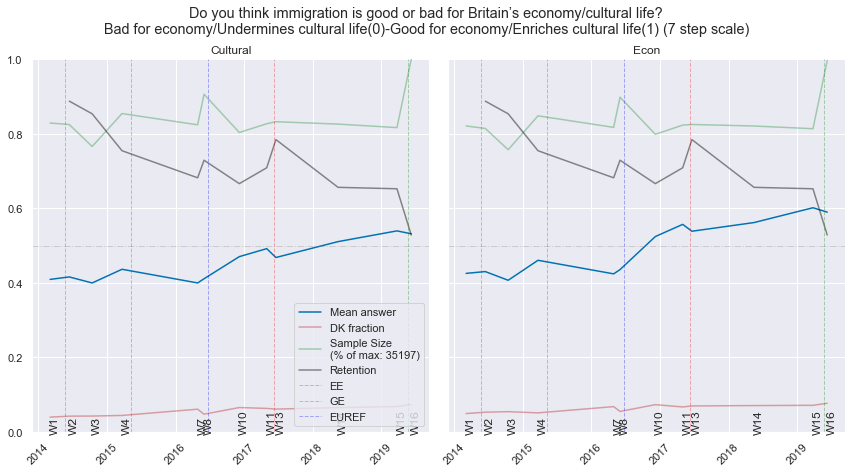

In [306]:
%%time
var_name = "immig"
title= "\n".join(["Do you think immigration is good or bad for Britain’s economy/cultural life?",
                  "Bad for economy/Undermines cultural life(0)-Good for economy/Enriches cultural life(1) (7 step scale)"])
specific_suffix_set = "(Econ|Cultural)"
col_wrap = 2
height   = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (2) immgSelf|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD

# Chart is a bit ugly because W12/13 only appear in a small/very small fraction of those cohorts (*I think* as top-up exercises)
# Bit heart-breaking, but probably need to be dropped for anything involving personal differences
# (/some painful model-based massive imputation to fill in all the gaps)

# Scale of movement of immigSelf is ... sloooow - but steady (particularly when the W12/13 fractions are dropped)
# Re: parties - another one where only the Con chart is really interesting

Wall time: 2min 12s


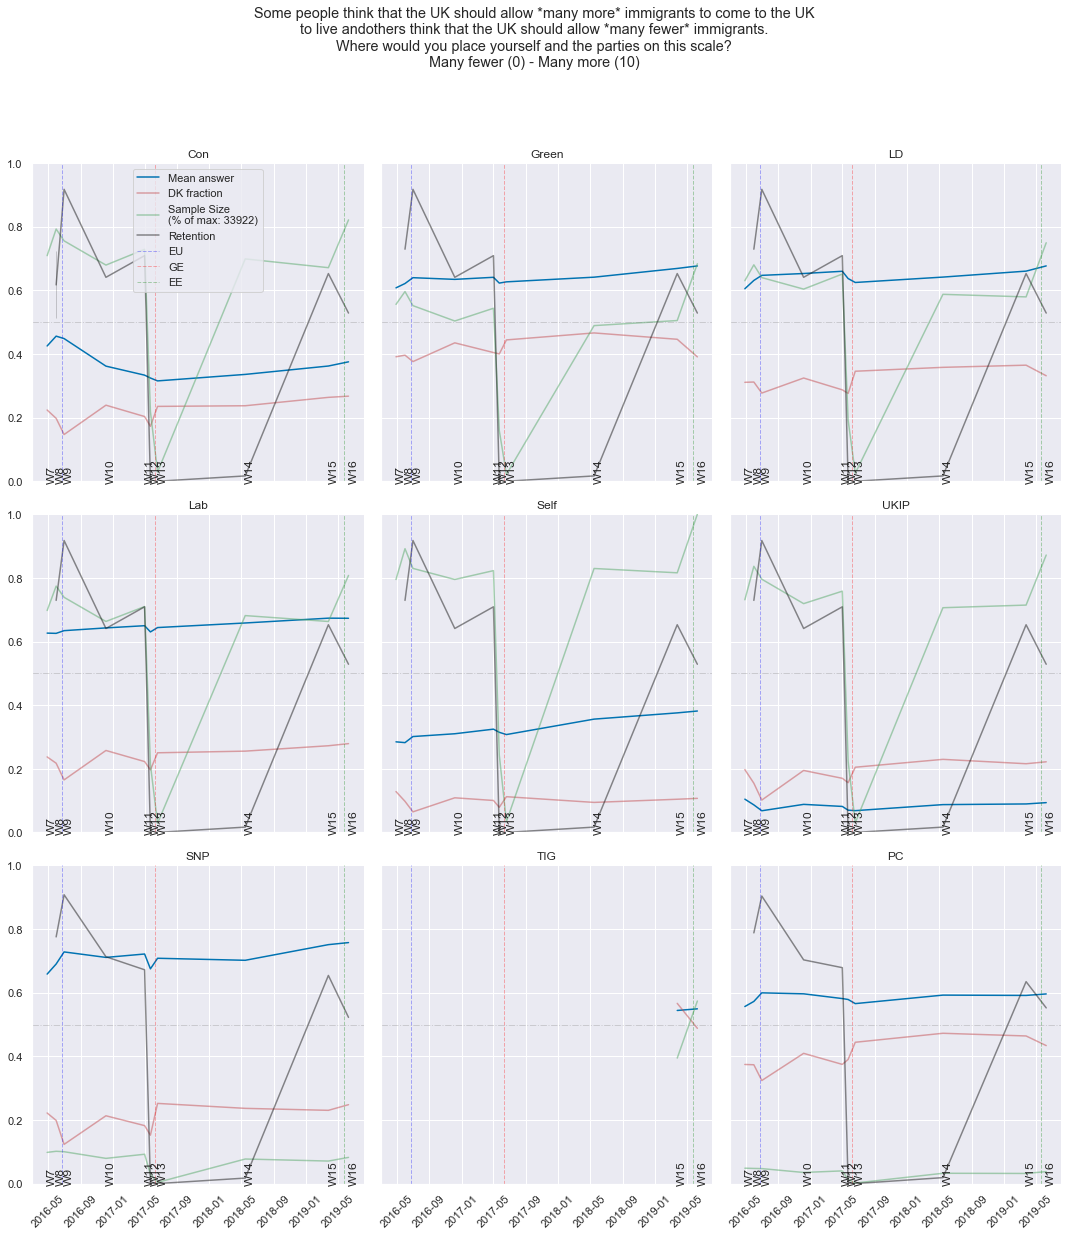

In [312]:
%%time
var_name = "immig"

title= "\n".join(["Some people think that the UK should allow *many more* immigrants to come to the UK",
                  "to live andothers think that the UK should allow *many fewer* immigrants.",
                  "Where would you place yourself and the parties on this scale?",
                  "Many fewer (0) - Many more (10)"])
specific_suffix_set = "(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)"
col_name="party"
col_wrap=3
height = 4

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [363]:
BES_Panel.drop( match(BES_Panel,"immig(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)(W12|W13)").index, axis=1, inplace=True)

Wall time: 2min 5s


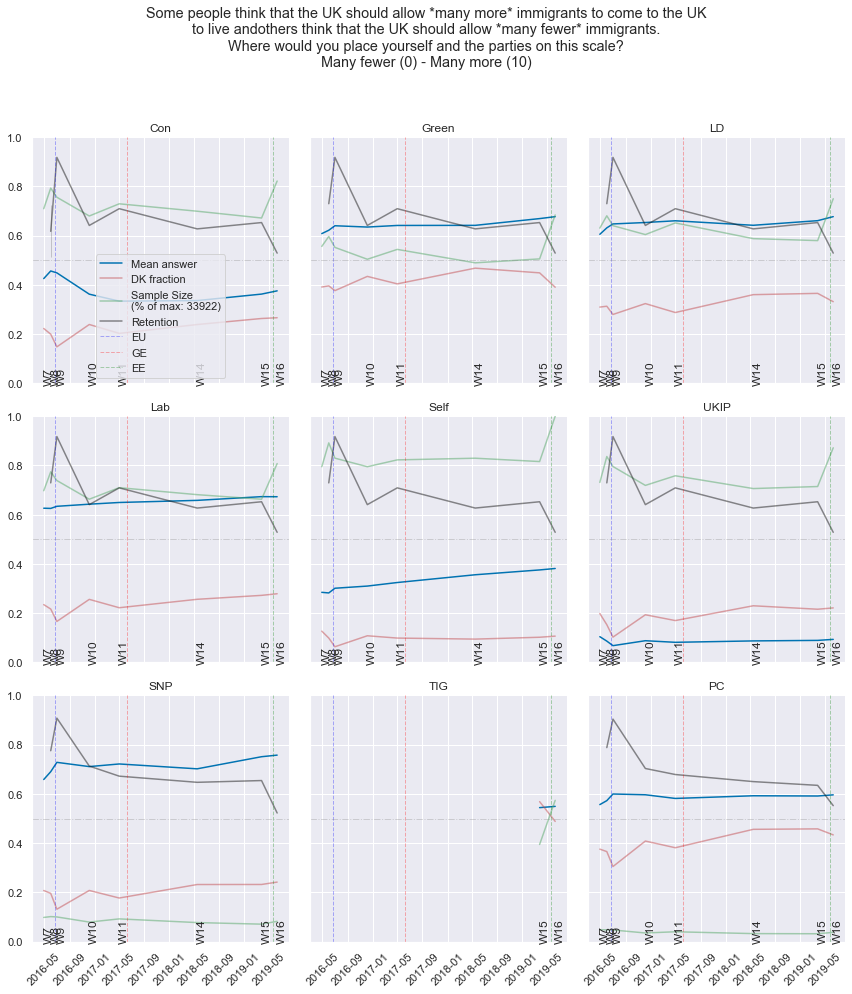

In [365]:
%%time
## now without those two waves


var_name = "immig"

title= "\n".join(["Some people think that the UK should allow *many more* immigrants to come to the UK",
                  "to live andothers think that the UK should allow *many fewer* immigrants.",
                  "Where would you place yourself and the parties on this scale?",
                  "Many fewer (0) - Many more (10)"])
specific_suffix_set = "(Self|Con|Lab|TIG|Brexit|Green|UKIP|PC|SNP|LD)"
col_name="party"
col_wrap=3
height = 4

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (3) studentsMore|euMore|asylumMore|familiesMore|noneuMore

Wall time: 38.7 s


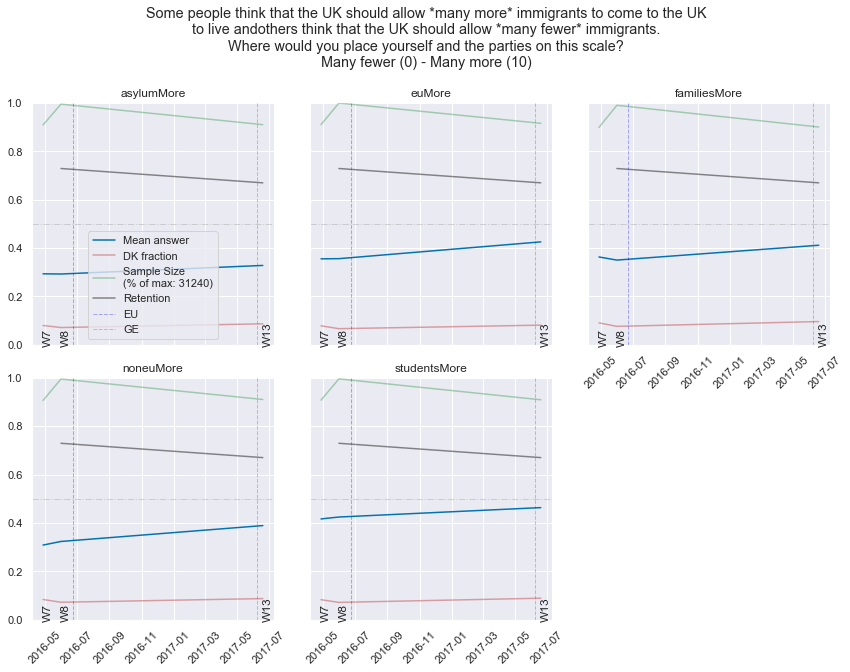

In [360]:
%%time
var_name = ""

title= "\n".join(["Some people think that the UK should allow *many more* immigrants to come to the UK",
                  "to live andothers think that the UK should allow *many fewer* immigrants.",
                  "Where would you place yourself and the parties on this scale?",
                  "Many fewer (0) - Many more (10)"])
specific_suffix_set = "(studentsMore|euMore|asylumMore|familiesMore|noneuMore)"
col_name="party"
col_wrap = 3
height   = 3

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (4) (labHandleImmig|govtHandleImmig)
# Supremely dull

Wall time: 12.5 s


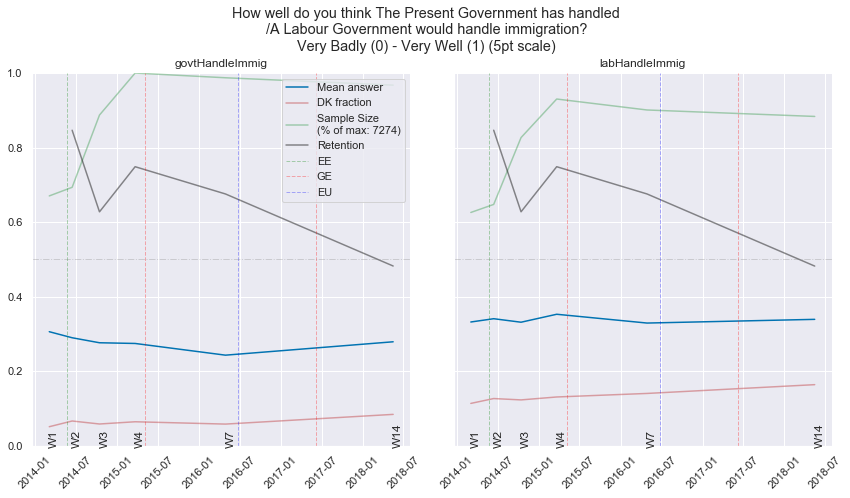

In [317]:
%%time
var_name = ""

title= "\n".join(["How well do you think The Present Government has handled",
                  "/A Labour Government would handle immigration?",
                  "Very Badly (0) - Very Well (1) (5pt scale)"])
specific_suffix_set = "(labHandleImmig|govtHandleImmig)"
col_name="party"
col_wrap=2
height = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (5) (immigrationLevel|immigContributeTake)
# immigrationLevel in theory could be used to extend immigSelf (v similar question) - even though it's rather "meh"

# immigContributeTake is a really important variable despite us only having it in two waves (and only a fraction of the cohort!)
# partly because it's the *right* two waves - and partly because it just crops up a lot as a driver

Wall time: 10.2 s


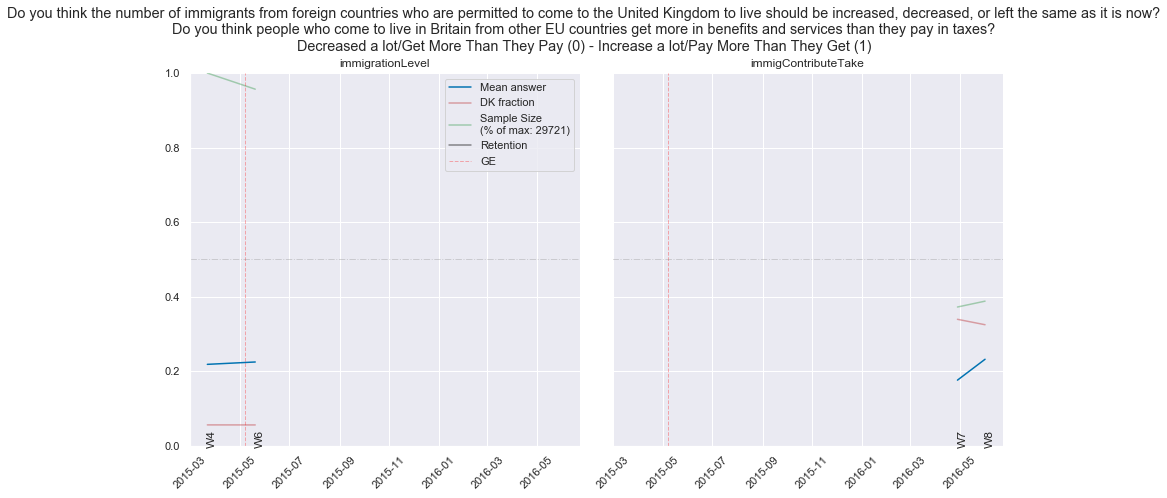

In [368]:
%%time
var_name = ""

title= "\n".join(["Do you think the number of immigrants from foreign countries who are permitted to come to the United Kingdom to live should be increased, decreased, or left the same as it is now?",
                  "Do you think people who come to live in Britain from other EU countries get more in benefits and services than they pay in taxes?",
                  "Decreased a lot/Get More Than They Pay (0) - Increase a lot/Pay More Than They Get (1)"
                  ])
specific_suffix_set = "(immigrationLevel|immigContributeTake)"
col_name="party"
col_wrap=2
height = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (6) (changeImmig|changeImmigLab|controlImmig)
# changeImmig is a very long panel, decent coverage - sharp change around euref (shame it doesn't appear in W9)
# changeImmigLab - dull!
# controlImmig has a unfortunate problem
# the W8 campaign sample would be perfect *but* it's not a full sample and the question shifts quite a lot
# (there's three different versions, but probably big difference is between W8/W9+ - how much control does the UK have/would the UK have after ...)

Wall time: 1min 16s


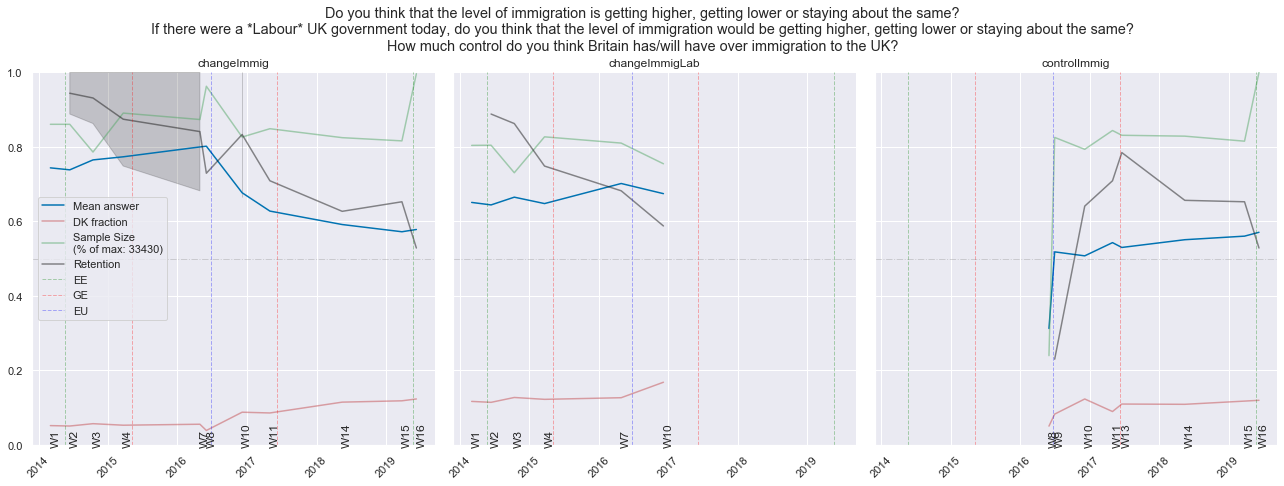

In [369]:
%%time
var_name = ""

title= "\n".join(["Do you think that the level of immigration is getting higher, getting lower or staying about the same?",
                  "If there were a *Labour* UK government today, do you think that the level of immigration would be getting higher, getting lower or staying about the same?",
                  "How much control do you think Britain has/will have over immigration to the UK?"
                  ])
specific_suffix_set = "(changeImmig|changeImmigLab|controlImmig)"
col_name="party"
col_wrap=3
height = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# I'll have to check that glitch in Retention out later

In [ ]:
# We should look into "negotiation_specifics" and "ukCoopMovement"

In [ ]:
# (5) (immigrantsWelfareState|effectsEUImmigration|euPriorityBalance)
# immigrantsWelfareState - this variable is super important (long profile, good sample size and it crops up in lots of regressions)


# effectsEUImmigration - "Do you think the following would be higher, lower or about the same if the UK leaves the European Union?"
    # important since this is an actual explicit *cause and effect in relation to the UK leaving the EU*
    # (and not, say, a Con government being elected/perception of UK politicians)
    
# euPriorityBalance - reflects the slow but continuous positive shift in UK attitudes to Freedom of Movement

Wall time: 1min 15s


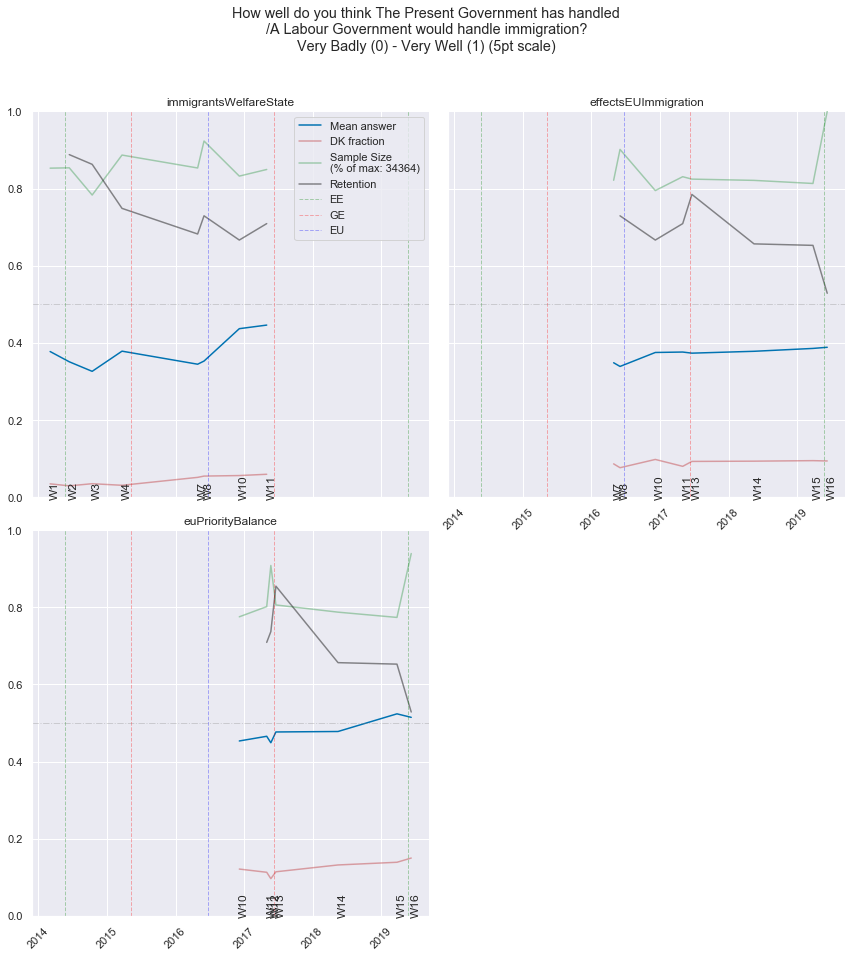

In [370]:
%%time
var_name = ""

title= "\n".join(["How well do you think The Present Government has handled",
                  "/A Labour Government would handle immigration?",
                  "Very Badly (0) - Very Well (1) (5pt scale)"])
specific_suffix_set = "(immigrantsWelfareState|effectsEUImmigration|euPriorityBalance)"
col_name="party"
col_wrap=3
height = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (6) responsibleImmig(Conservatives|LibDems|Labour|ScottishGovt|WelshGovt|None|DontKnow)

# interesting, because it directly follows from changeImmig questions ...
# ... and yet the trends are also deeply boring

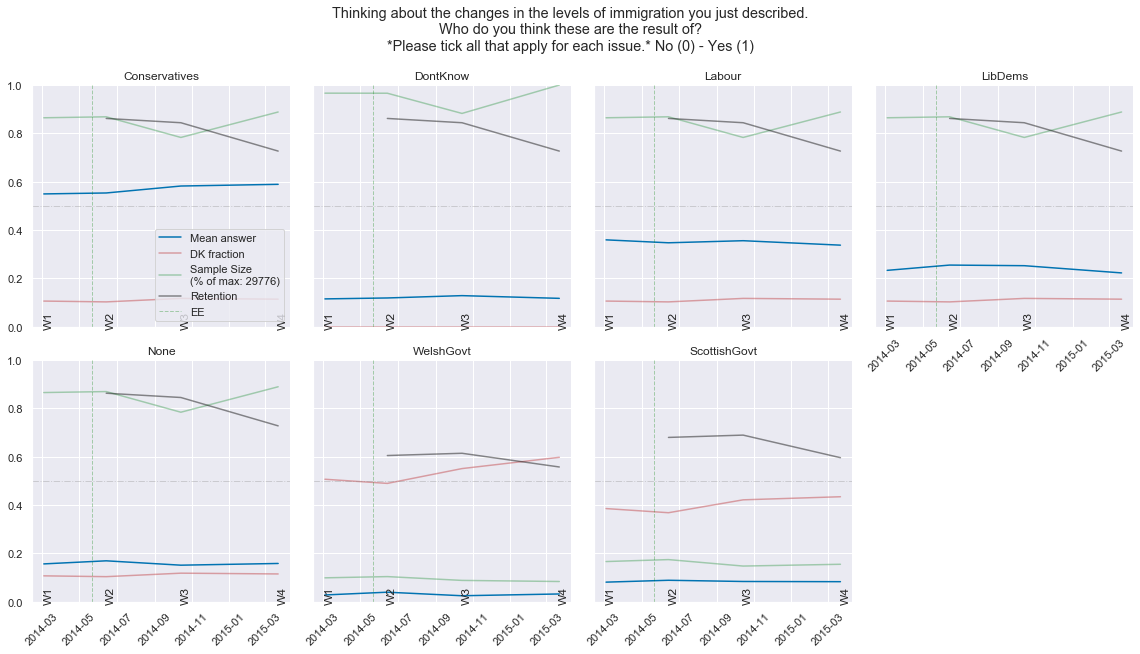

In [358]:
# %%time
var_name = "responsibleImmig"

title= "\n".join(["Thinking about the changes in the levels of immigration you just described.",
                  "Who do you think these are the result of?",
                  "*Please tick all that apply for each issue.* No (0) - Yes (1)"])
specific_suffix_set = "(Conservatives|LibDems|Labour|ScottishGovt|WelshGovt|None|DontKnow)"
col_name="party"
col_wrap=4
height = 4

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (7) achieveReduceImmig(Brexit|Con|Grn|LD|Lab|None|PC|SNP|TIG|UKIP)
# Wow - charts for LD/Green are not broken - there are some Yes's - just very few
# Con pattern interesting - the way it ever-so-briefly kisses UKIP before collapsing back into the GE
# UKIP is trending down even before the euref

Wall time: 2min 36s


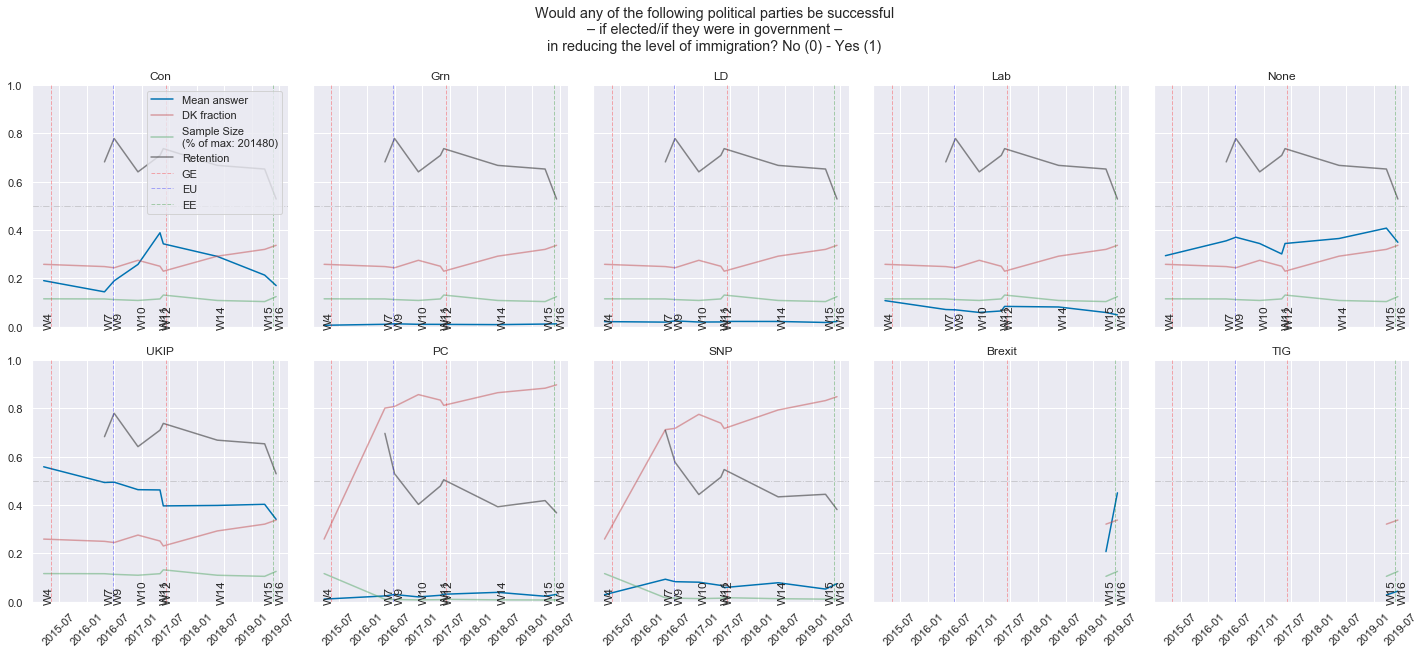

In [352]:
%%time
var_name = "achieveReduceImmig"

title= "\n".join(["Would any of the following political parties be successful",
                  " – if elected/if they were in government – ",
                  "in reducing the level of immigration? No (0) - Yes (1)"])
specific_suffix_set = "(Brexit|Con|Grn|LD|Lab|None|PC|SNP|TIG|UKIP)"
col_name="party"
col_wrap=5
height = 4

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
# (8) (conPriorities_immig|labPriorities_immig|ldPriorities_immig|ukipPriorities_immig)

# low sample size even at peak
# bump around 2015 GE
# 

In [345]:
# my time plotting function assumes variable names won't contain _ - quick hack to circumvent having to change that
BES_Panel[[x.replace("_i","I") for x in search(BES_Panel,"Priorities_immig").index]] = BES_Panel[[x for x in search(BES_Panel,"Priorities_immig").index]]

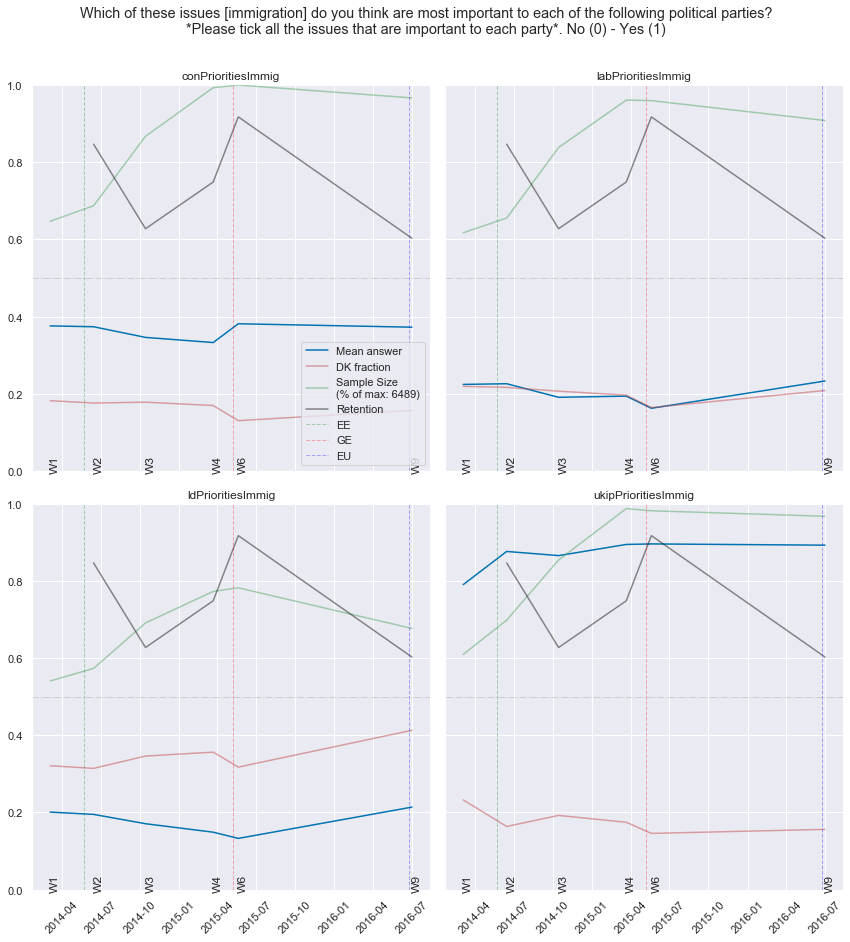

In [348]:
# %%time
var_name = ""

title= "\n".join(["Which of these issues [immigration] do you think are most important to each of the following political parties?",
                  "*Please tick all the issues that are important to each party*. No (0) - Yes (1)"])
specific_suffix_set = "(conPrioritiesImmig|labPrioritiesImmig|ldPrioritiesImmig|ukipPrioritiesImmig)"
col_name="party"
col_wrap=2
height = 6

flat_df_num = plot_time_series(var_name=var_name,specific_suffix_set=specific_suffix_set,title=title,col_name="party",
                               col_wrap=col_wrap,treatment="immig_timeseries")

In [ ]:
### Here's the code for the nice, explorable bokeh charts

# would like to redo with a smoothed curve (moving average?) and cleverer options for zooming in

In [ ]:
#redo with weighted mean
# [ref_year]
min_sample_size=50
# df = flat_df_num[ref_year].groupby(['wave','party']).mean().reset_index()
df = flat_df_num.groupby(['wave','party']).agg( lambda x: weighted_mean(x) ).reset_index()
df["N"] = flat_df_num.groupby(['wave','party']).count().reset_index()["immignum"]
df[["wt","dk"]] = flat_df_num.groupby(['wave','party']).mean().reset_index()[["wt","dk"]]
df["stdev"] = flat_df_num.groupby(['wave','party'])["immignum"].std().reset_index()["immignum"]
df = df[ df["N"]>=min_sample_size ]
# plot in bokeh so we can explore!
df = df.rename(columns={"immig_wts":"immignum"})
df = df.pivot(index = "wave",columns="party", values=['immignum', 'dk', 'N', 'stdev'])
df = df.reset_index()
df.columns = ["_".join(x).strip("_") for x in df.columns]
# df = df[ref_year]

ref_year = (df["wave"]>"2016-01-01") & (df["wave"]<"2016-12-30")
df = df[ref_year]

df["stdev_Econ"][df["N_Econ"]>10].hist(bins=100)





source = ColumnDataSource(df)

dk=False

p1 = figure(x_axis_type="datetime",x_axis_label = "Response Date",
            y_axis_label="mean answer within each day (N>="+str(min_sample_size)+")",
            plot_width=600, plot_height=280, title="Do you think immigration is bad(0) or good(1) for Britain’s economy? (7pt scale)",
            tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select")
p1.scatter('wave','immignum_Econ', source=source, color='blue')



p2 = figure(x_axis_type="datetime",x_axis_label = "Response Date",
            y_axis_label="mean answer within each day (N>="+str(min_sample_size)+")",
            plot_width=600, plot_height=280, title="Do you think that immigration undermines(0) or enriches(1) Britain’s cultural life? (7pt scale)",
            tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select")
p2.scatter('wave', 'immignum_Cultural', source=source, color='red')

if dk:

    p1_dk = figure(x_axis_type="datetime",x_axis_label = "Response Date",
                y_axis_label="mean answer within each day (N>="+str(min_sample_size)+")",
                plot_width=600, plot_height=280, title="Do you think immigration is bad(0) or good(1) for Britain’s economy? (% Don't know)",
                tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select")
    p1_dk.scatter('wave', 'dk_Econ', source=source, color='blue')


    p2_dk = figure(x_axis_type="datetime",x_axis_label = "Response Date",
                y_axis_label="mean answer within each day (N>="+str(min_sample_size)+")",
                plot_width=600, plot_height=280, title="Do you think that immigration undermines(0) or enriches(1) Britain’s cultural life? (% Don't know)",
                tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select")
    p2_dk.scatter('wave', 'dk_Cultural', source=source, color='blue')



p1.x_range = p2.x_range
if dk:
    p1.x_range = p1_dk.x_range
    p2.x_range = p2_dk.x_range
    p1_dk.x_range = p2_dk.x_range
if dk:
    layout = column( row(p1,p1_dk) , row(p2,p2_dk) )
else:
    layout = column( p1 , p2 )
# Import HoverTool from bokeh.models
from bokeh.models import HoverTool

# Create a HoverTool object: hover
Econ_hover = HoverTool(tooltips = [
                              ('Date','@wave{%F}'),
#                               ('Date','@wave'),
                              ('Value','@immignum_Econ'),
                              ('Sample Size','@N_Econ'),
                              ("Standard Deviation",'@stdev_Econ'),
                              ("Don't Know",'@dk_Econ'),
                             ],
                  formatters={'wave': 'datetime'},
                  # display a tooltip whenever the cursor is vertically in line with a glyph
                  mode='vline')

# Create a HoverTool object: hover
Cultural_hover = HoverTool(tooltips = [
                              ('Date','@wave{%F}'),
#                               ('Date','@wave'),
                              ('Value','@immignum_Cultural'),
                              ('Sample Size','@N_Cultural'),
                              ("Standard Deviation",'@stdev_Cultural'),
                              ("Don't Know",'@dk_Cultural'),
                             ],
                  formatters={'wave': 'datetime'},
                  # display a tooltip whenever the cursor is vertically in line with a glyph
                  mode='vline')

# Add the HoverTool object to figure p
p1.add_tools(Econ_hover)
p2.add_tools(Cultural_hover)

if dk:
    p1_dk.add_tools(Econ_hover)
    p2_dk.add_tools(Cultural_hover)

show(layout)